<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/tool_comparison/adult_census/WideDeepModel_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip show tensorflow scikit-learn

Name: tensorflow
Version: 2.3.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, absl-py, astunparse, tensorboard, google-pasta, wheel, h5py, scipy, numpy, opt-einsum, grpcio, wrapt, termcolor, gast, protobuf, keras-preprocessing, tensorflow-estimator
Required-by: fancyimpute
---
Name: scikit-learn
Version: 0.22.2.post1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, scipy, joblib
Required-by: yellowbrick, umap-learn, textgenrnn, sklearn, sklearn-pandas, mlxtend, lucid, lightgbm, librosa, imbalanced-learn, fancyimpute


In [2]:
import os, pprint

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.experimental import LinearModel, WideDeepModel
from tensorflow.keras import Sequential, Input, layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

## データセット読み込み
- [国税調査データセット:https://www.openml.org/d/1590](https://www.openml.org/d/1590)

In [3]:
%%time
DATA_ID = '1590' #@param{type:'string'}

# データセットをフェッチ
result = fetch_openml(data_id=DATA_ID,
                    as_frame=True)
X = result.data
y = result.target
x_cols = result.feature_names
y_col = result.target_names

display(x_cols)
display(X.head())
display(y_col)
display(y.head())


def proc_y(y):
    '''ラベルの加工'''

    def _one_hot_encode(y):
        '''ワンホットエンコードしたnumpy.ndarrayを返す'''
        return pd.get_dummies(y)

    proc_y = _one_hot_encode(y=y)
    return proc_y


def proc_X(X, one_hot_encode_cols):
    '''特徴量の加工'''

    def _one_hot_encode(X, X_cols, drop_first=True):
        '''ワンホットエンコードしたDataframeを返す'''
        return pd.get_dummies(X, columns=X_cols,
                              drop_first=drop_first)

    proc_X = _one_hot_encode(X=X, X_cols=one_hot_encode_cols)
    return proc_X


one_hot_encode_cols = ['workclass', 'education', 'marital-status', 'occupation',
                       'relationship', 'race', 'sex', 'native-country']
X=proc_X(X=X, one_hot_encode_cols=one_hot_encode_cols)
y=proc_y(y=y)

display(X.head())
display(y.head())


SEED = 7 #@param{type:'number'}
SPLIT = 0.2 #@param{type:'number'}

train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size=SPLIT,
                                                    random_state=SEED,
                                                    shuffle=True)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y,
                                                  test_size=SPLIT,
                                                  random_state=SEED,
                                                  shuffle=True)

display('train shape:{}'.format(train_X.shape))
display('val shape:{}'.format(val_X.shape))
display('test shape:{}'.format(test_X.shape))



['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country']

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States


['class']

0    <=50K
1    <=50K
2     >50K
3     >50K
4    <=50K
Name: class, dtype: category
Categories (2, object): ['>50K', '<=50K']

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Self-emp-not-inc,workclass_Self-emp-inc,workclass_Federal-gov,workclass_Local-gov,workclass_State-gov,workclass_Without-pay,workclass_Never-worked,education_Some-college,education_11th,education_HS-grad,education_Prof-school,education_Assoc-acdm,education_Assoc-voc,education_9th,education_7th-8th,education_12th,education_Masters,education_1st-4th,education_10th,education_Doctorate,education_5th-6th,education_Preschool,marital-status_Divorced,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,marital-status_Married-spouse-absent,marital-status_Married-AF-spouse,occupation_Craft-repair,occupation_Other-service,occupation_Sales,occupation_Exec-managerial,occupation_Prof-specialty,occupation_Handlers-cleaners,...,native-country_Cambodia,native-country_England,native-country_Puerto-Rico,native-country_Canada,native-country_Germany,native-country_Outlying-US(Guam-USVI-etc),native-country_India,native-country_Japan,native-country_Greece,native-country_South,native-country_China,native-country_Cuba,native-country_Iran,native-country_Honduras,native-country_Philippines,native-country_Italy,native-country_Poland,native-country_Jamaica,native-country_Vietnam,native-country_Mexico,native-country_Portugal,native-country_Ireland,native-country_France,native-country_Dominican-Republic,native-country_Laos,native-country_Ecuador,native-country_Taiwan,native-country_Haiti,native-country_Columbia,native-country_Hungary,native-country_Guatemala,native-country_Nicaragua,native-country_Scotland,native-country_Thailand,native-country_Yugoslavia,native-country_El-Salvador,native-country_Trinadad&Tobago,native-country_Peru,native-country_Hong,native-country_Holand-Netherlands
0,25.0,226802.0,7.0,0.0,0.0,40.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38.0,89814.0,9.0,0.0,0.0,50.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,28.0,336951.0,12.0,0.0,0.0,40.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,44.0,160323.0,10.0,7688.0,0.0,40.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18.0,103497.0,10.0,0.0,0.0,30.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,>50K,<=50K
0,0,1
1,0,1
2,1,0
3,1,0
4,0,1


'train shape:(31258, 97)'

'val shape:(7815, 97)'

'test shape:(9769, 97)'

CPU times: user 1.37 s, sys: 78.6 ms, total: 1.45 s
Wall time: 6.26 s


## WideDeepモデル作成

In [13]:
%%time
def WideDeep_fn(X_train_dnn, input_shape_dnn, num_class, dropout_seed_dnn=None):
    '''WideDeepModelの定義'''

    def _LinearModel_fn(num_class):
        '''線形回帰モデルの定義'''
        linear_model = LinearModel(units=num_class,
                                   activation='softmax')
        return linear_model

    def _DNNModel_fn(input_shape, num_class, dropout_seed, X_train):
        '''DNNモデルの定義'''

        def _initialize_std_layer(X_train):
            '''標準化層の初期化'''
            norm_layer = Normalization()
            norm_layer.adapt(X_train)
            return norm_layer
        
        dnn_model = Sequential()
        dnn_model.add(Input(shape=input_shape))
        
        # 標準化レイヤーの追加
        std_layer = _initialize_std_layer(X_train)
        dnn_model.add(std_layer)

        # データ解析レイヤーの追加
        dnn_model.add(layers.Dense(units=256, activation='relu'))
        dnn_model.add(layers.Dropout(rate=0.3, seed=dropout_seed))
        dnn_model.add(layers.Dense(units=128, activation='relu'))
        dnn_model.add(layers.Dropout(rate=0.3, seed=dropout_seed))

        # 出力レイヤーの追加
        dnn_model.add(layers.Dense(units=num_class, activation='softmax'))
        return dnn_model


    linear_model = _LinearModel_fn(num_class=num_class)
    dnn_model = _DNNModel_fn(input_shape=input_shape_dnn,
                             num_class=num_class,
                             dropout_seed=dropout_seed_dnn,
                             X_train=X_train_dnn)
    
    combined_model = WideDeepModel(linear_model=linear_model,
                                   dnn_model=dnn_model,
                                   activation='softmax')

    # 勾配アルゴリズム(線形モデル用, 深層モデル用), 損失関数, 評価関数
    combined_model.compile(optimizer=['sgd', 'adam'],
                           loss='categorical_crossentropy', 
                           metrics=['accuracy'])
    
    return combined_model



def take_linear_and_dnn_cols(fetch_X_cols, encoded_cols, df_cols):
    '''DNNと線形モデル用のカラム名を返す
    INFO : WideDeepModel用'''
    dnn_cols = set(fetch_X_cols) ^ set(encoded_cols)
    linear_cols = set(df_cols) ^ set(dnn_cols)
    return linear_cols, dnn_cols


linear_cols, dnn_cols = take_linear_and_dnn_cols(x_cols, one_hot_encode_cols, X.columns)
# DNNモデルの入力に使用する特徴量の取得
train_X_dnn = train_X.loc[:, dnn_cols].values
dnn_input_shape = (train_X.loc[:, dnn_cols].shape[1], )
# 線形回帰モデルが使用する特徴量名の取得
linear_cols = train_X.drop(columns=dnn_cols).columns

# 出力層のユニット数
num_class = train_y.shape[1]

# モデル定義
classifier = WideDeep_fn(X_train_dnn=train_X_dnn, 
                        input_shape_dnn=dnn_input_shape,
                        num_class=num_class,
                        dropout_seed_dnn=SEED)

display(classifier)


def X_data_WideDeep_fn(X_df, linear_cols, dnn_cols):
    '''WideDeepモデル用の特徴量データセットの作成'''
    return [X_df[linear_cols].values, X_df[dnn_cols].values]


train_X_WideDeep = X_data_WideDeep_fn(X_df=train_X, linear_cols=linear_cols, dnn_cols=dnn_cols)
val_X_WideDeep = X_data_WideDeep_fn(X_df=val_X, linear_cols=linear_cols, dnn_cols=dnn_cols)
test_X_WideDeep = X_data_WideDeep_fn(X_df=test_X, linear_cols=linear_cols, dnn_cols=dnn_cols)

CPU times: user 99.1 ms, sys: 12 ms, total: 111 ms
Wall time: 111 ms


In [14]:
EPOCH =   700#@param{type:'number'}
BATCH_SIZE = 256 #@param{type:'number'}

# 早期停止コールバックの定義
es = EarlyStopping(monitor='val_loss',
                   patience=5)

In [15]:
%%time
classifier.fit(x=train_X_WideDeep,
                y=train_y,
                epochs=EPOCH,
                batch_size=BATCH_SIZE,
                validation_data=(val_X_WideDeep, val_y),
                callbacks=[es]
                )

Epoch 1/700
123/123 [==============================] - 1s 7ms/step - loss: 0.4979 - accuracy: 0.8020 - val_loss: 0.4691 - val_accuracy: 0.8171
Epoch 2/700
123/123 [==============================] - 1s 5ms/step - loss: 0.4602 - accuracy: 0.8226 - val_loss: 0.4544 - val_accuracy: 0.8219
Epoch 3/700
123/123 [==============================] - 1s 5ms/step - loss: 0.4490 - accuracy: 0.8260 - val_loss: 0.4446 - val_accuracy: 0.8273
Epoch 4/700
123/123 [==============================] - 1s 6ms/step - loss: 0.4410 - accuracy: 0.8278 - val_loss: 0.4382 - val_accuracy: 0.8258
Epoch 5/700
123/123 [==============================] - 1s 6ms/step - loss: 0.4345 - accuracy: 0.8304 - val_loss: 0.4329 - val_accuracy: 0.8294
Epoch 6/700
123/123 [==============================] - 1s 6ms/step - loss: 0.4301 - accuracy: 0.8308 - val_loss: 0.4287 - val_accuracy: 0.8305
Epoch 7/700
123/123 [==============================] - 1s 6ms/step - loss: 0.4260 - accuracy: 0.8344 - val_loss: 0.4241 - val_accuracy: 0.8339

# モデルの構造を可視化

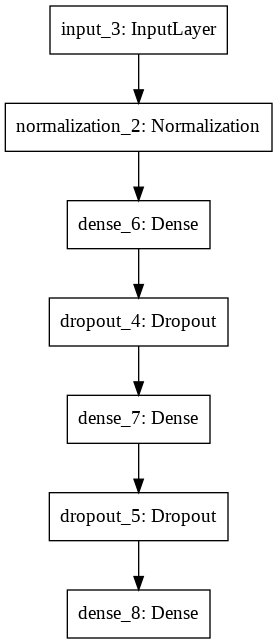

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 6)                 13        
_________________________________________________________________
dense_6 (Dense)              (None, 256)               1792      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 258       
Total params: 34,959
Trainable params: 34,946
Non-trainable params: 13
_________________________________________________

None

In [16]:
def display_dnn_model(model):
    '''モデルの構造を表示'''
    display(plot_model(model))
    display(model.summary())

display_dnn_model(model=classifier.dnn_model)

## モデルの評価

### Kerasの組み込み評価関数

In [18]:
%%time
score = classifier.evaluate(x=test_X_WideDeep, y=test_y, batch_size=BATCH_SIZE)
display('loss : {}, accuracy : {}'.format(score[0], score[1]))

39/39 [==============================] - 0s 2ms/step - loss: 0.3847 - accuracy: 0.8436


'loss : 0.3846505582332611, accuracy : 0.8435868620872498'

CPU times: user 144 ms, sys: 9.16 ms, total: 154 ms
Wall time: 132 ms


In [19]:
classifier.predict(train_X_WideDeep)

array([[0.12216813, 0.8778319 ],
       [0.12373757, 0.8762625 ],
       [0.32086942, 0.67913055],
       ...,
       [0.24712162, 0.7528783 ],
       [0.25723538, 0.7427646 ],
       [0.21811591, 0.78188413]], dtype=float32)

### sklearnの評価関数

In [27]:
%%time
def predict_classes(model, x):
    '''ラスラベルの予測を取得'''
    return np.argmax(model.predict(x), axis=-1)


# 予測結果の取得
train_y_pred = predict_classes(classifier, train_X_WideDeep)
val_y_pred = predict_classes(classifier, val_X_WideDeep)
test_y_pred = predict_classes(classifier, test_X_WideDeep)


def encode_label_classes(one_hot_encode_y):
    '''ワンホットエンコードをラベルエンコードに変換'''
    return np.argmax(one_hot_encode_y.values, axis=-1)

train_report = classification_report(y_true=encode_label_classes(train_y),
                                     y_pred=train_y_pred)
val_report = classification_report(y_true=encode_label_classes(val_y),
                                   y_pred=val_y_pred)
test_report = classification_report(y_true=encode_label_classes(test_y),
                                    y_pred=test_y_pred)

print(train_report)
print('----- -----')
print(val_report)
print('----- -----')
print(test_report)

              precision    recall  f1-score   support

           0       0.80      0.53      0.64      7477
           1       0.87      0.96      0.91     23781

    accuracy                           0.86     31258
   macro avg       0.83      0.74      0.77     31258
weighted avg       0.85      0.86      0.84     31258

----- -----
              precision    recall  f1-score   support

           0       0.79      0.52      0.63      1900
           1       0.86      0.96      0.91      5915

    accuracy                           0.85      7815
   macro avg       0.83      0.74      0.77      7815
weighted avg       0.84      0.85      0.84      7815

----- -----
              precision    recall  f1-score   support

           0       0.77      0.49      0.60      2310
           1       0.86      0.95      0.90      7459

    accuracy                           0.84      9769
   macro avg       0.81      0.72      0.75      9769
weighted avg       0.84      0.84      0.83      9

array([1, 1, 0, ..., 1, 1, 1])